# Dependencies

In [1]:
import graph_tool.all as gt
import pandas as pd # for writing output graph TSV files
import numpy as np
import random
import scipy.stats as stats

# Generate the graph according to the blockmodel and parameters

Number of blocks: 8
Block distribution: [ 0.13538804  0.10158502  0.08580466  0.12338089  0.12905584  0.09097296
  0.14865246  0.18516013]
Number of nodes: 500
Number of edges: 9277
Avg. Number of nodes per block: 62
# Within-block edges / # Between-blocks edges: 2.74828282828


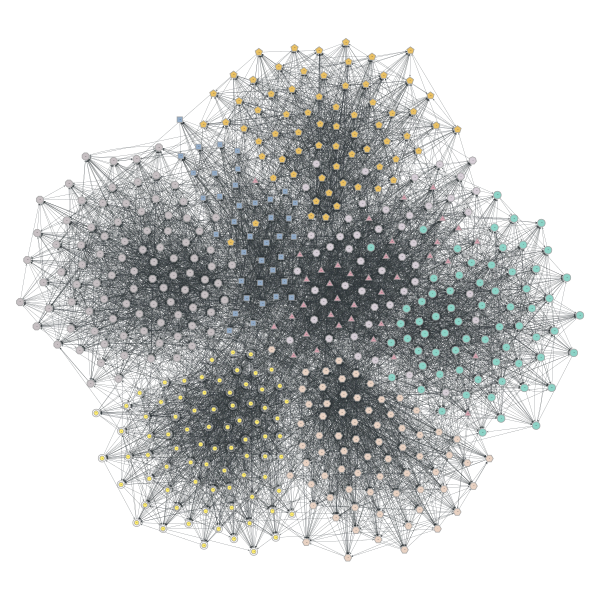

In [2]:
N = 500 # number of nodes
save_graph = True
draw_graph = True

file_name = './simulated_blockmodel_graph_{:d}_nodes'.format(N) # output file name
num_blocks = int(N**0.35) # number of blocks grows sub-linearly with number of nodes. Exponent is a parameter.
print('Number of blocks: {}'.format(num_blocks))

# parameters for the Power-Law degree distribution
powerlaw_exponent = -2.5
min_degree = min(10,N/(num_blocks*4)) # node degree range is adjusted lower when the blocks have few nodes
max_degree = min(100,N/num_blocks) 

# sparsity parameter (1-density fraction of the edges will be removed)
density = 1

# define discrete power law distribution
def discrete_power_law(a, min_v, max_v):
    x = np.arange(min_v, max_v+1, dtype='float')
    pmf = x**a
    pmf /= pmf.sum()
    return stats.rv_discrete(values=(range(min_v, max_v+1), pmf))

# set in-degree and out-degree distribution
rv_indegree = discrete_power_law(powerlaw_exponent,min_degree,max_degree)
rv_outdegree = discrete_power_law(powerlaw_exponent,min_degree,max_degree)

# define the return function for in and out degrees
def degree_distribution_function(rv1, rv2):
    return (rv1.rvs(size=1), rv2.rvs(size=1))

# this parameter adjusts the ratio between the total number of within-block edges and between-block edges
ratio_within_over_between = 5  

# set the within-block and between-block edge strength accordingly
def inter_block_strength(a, b):
    if a == b: # within block interaction strength 
        return 1 
    else: # between block interaction strength 
        avg_within_block_nodes = float(N)/num_blocks
        avg_between_block_nodes = N-avg_within_block_nodes
        return avg_within_block_nodes/avg_between_block_nodes/ratio_within_over_between 

# draw block membership distribution from a Dirichlet random variable
block_size_heterogeneity = 1 #3; # larger means the block sizes are more uneven
block_distribution = np.random.dirichlet(np.ones(num_blocks)*10/block_size_heterogeneity, 1)[0]
print('Block distribution: {}'.format(block_distribution))

# draw block membership for each node
block_membership_vector = np.where(np.random.multinomial(n = 1, size = N, pvals = block_distribution))[1]
true_partition = block_membership_vector

# generate the graph
if (float(gt.__version__[0:4])>=2.20): # specify inter-block strength through edge_probs in later versions
    g_sample, block_membership = gt.random_graph(N, lambda: degree_distribution_function(rv_indegree, rv_outdegree), \
    directed = True, model = "blockmodel", block_membership = block_membership_vector, edge_probs = inter_block_strength, n_iter = 10, verbose = True)
else: # specify inter-block strength through vertex_corr in earlier versions
    g_sample, block_membership = gt.random_graph(N, lambda: degree_distribution_function(rv_indegree, rv_outdegree), \
    directed = True, model = "blockmodel", block_membership = block_membership_vector, vertex_corr = inter_block_strength, n_iter = 10, verbose = True)

# remove (1-density) percent of the edges
edge_filter = g_sample.new_edge_property('bool')
edge_filter.a = stats.bernoulli.rvs(density, size=edge_filter.a.shape)
g_sample.set_edge_filter(edge_filter)
g_sample.purge_edges()

# store the nodal block memberships in a vertex property
g_sample.vertex_properties["block_membership"] = block_membership

# compute and report basic statistics on the generated graph   
bg, bb, vcount, ecount, avp, aep = gt.condensation_graph(g_sample, block_membership, self_loops=True)
edge_count_between_blocks = np.zeros((num_blocks,num_blocks))
for e in bg.edges():
    edge_count_between_blocks[bg.vertex_index[e.source()], bg.vertex_index[e.target()]] = ecount[e]
num_within_block_edges = sum(edge_count_between_blocks.diagonal())
num_between_block_edges = g_sample.num_edges() - num_within_block_edges
# print count statistics
print('Number of nodes: {}'.format(N))
print('Number of edges: {}'.format(g_sample.num_edges()))
print('Avg. Number of nodes per block: {}'.format(N/num_blocks))
print('# Within-block edges / # Between-blocks edges: {}'.format(num_within_block_edges/num_between_block_edges))

if save_graph: # output the graph and truth partition to TSV files with standard format
    g_sample.save('{}.gt.bz2'.format(file_name)) # save graph-tool graph object
    # store edge list
    edge_list = np.zeros((g_sample.num_edges(),3),dtype=int)
    # populate the edge list. 
    counter = 0;
    for e in g_sample.edges(): # iterate through all edges (edge list access is not available in all versions of graph-tool)
        edge_list[counter,0] = int(e.source()) + 1; # nodes are indexed starting at 1 in the standard format  
        edge_list[counter,1] = int(e.target()) + 1; # nodes are indexed starting at 1 in the standard format 
        edge_list[counter,2] = 1; # all edges are weighted equally at 1 in this generator
        counter += 1
    # write graph TSV file using pandas DataFrame
    df_graph = pd.DataFrame(edge_list)
    df_graph.to_csv('{}.tsv'.format(file_name), sep = '\t', header = False, index = False)  
    # write truth partition TSV file using pandas DataFrame; nodes and blocks are indexed starting at 1 in the standard format 
    df_partition = pd.DataFrame(np.column_stack((np.arange(N)+1,true_partition+1))) 
    df_partition.to_csv('{}_truePartition.tsv'.format(file_name), sep = '\t', header = False, index = False)  
    
if draw_graph and N <= 5000: # visualize the generated network
    g_sample.vp['pos'] = gt.sfdp_layout(g_sample)
    gt.graph_draw(g_sample, inline=True, pos=g_sample.vp['pos'], edge_pen_width=0.2, edge_marker_size=2, vertex_text = g_sample.vertex_index, vertex_font_size=1, vertex_shape = block_membership, vertex_fill_color = block_membership, output_size=(600,600))
    if save_graph: # save the node position
        g_sample.save('{}.gt.bz2'.format(file_name))

# Divide graph into streaming parts

In [3]:
streaming_mode = 1; # 0 for random samples of edges over time. 1 for snow-ball sampling of graph over time.
num_stages = 10; # number of stages to divide the graph into
num_nodes_per_stage = int(g_sample.num_vertices() / num_stages)

# store edge list
edge_list = np.zeros((g_sample.num_edges(),3),dtype=int)
# populate the edge list. 
counter = 0;
for e in g_sample.edges(): # iterate through all edges (access edge list with .get_edges() in later versions of graph-tool)
    edge_list[counter,0] = int(e.source()) 
    edge_list[counter,1] = int(e.target())
    edge_list[counter,2] = 1; # all edges are weighted equally at 1 in this generator
    counter += 1

if streaming_mode == 0: # randomly assign edges to each of the graph stage
    mode = "edgeSample"
    edge_assignment = np.random.randint(num_stages, size = g_sample.num_edges())
else: # snowball sample the graph 
    mode = "snowball"
    degrees = np.array(g_sample.degree_property_map('total').a)
    starting_node = np.argmax(degrees) # start from a node with highest degree
    nodes_already_observed = set()
    nodes_in_current_stage = set([g_sample.vertex(starting_node)])
    nodes_to_expand_to = set(g_sample.vertex(starting_node).all_neighbours())
    edge_assignment = np.ones(g_sample.num_edges(), dtype=int)*-1
    for stage in range(num_stages-1): # snowball sample to build each stage of the streaming graph
        while len(nodes_in_current_stage) < num_nodes_per_stage: # expand until the current stage has the right number of nodes
            if (len(nodes_in_current_stage) + len(nodes_to_expand_to) <= num_nodes_per_stage):
                nodes_expanded = nodes_to_expand_to.copy() # expand all the available nodes
            else: # expand a randomly sampled fraction of the available nodes
                nodes_expanded = set(random.sample(nodes_to_expand_to, (num_nodes_per_stage-len(nodes_in_current_stage))))
            nodes_in_current_stage.update(nodes_expanded)
            nodes_to_expand_to.discard(nodes_expanded)
            # update the available nodes to expand to next
            for v in nodes_expanded: 
                nodes_to_expand_to.update(v.all_neighbours())
            nodes_to_expand_to = nodes_to_expand_to.difference(nodes_in_current_stage.union(nodes_already_observed))
        nodes_already_observed = nodes_already_observed.union(nodes_in_current_stage)
        node_idx_current_stage = np.array([g_sample.vertex_index[v] for v in nodes_in_current_stage])
        node_idx_observed = np.array([g_sample.vertex_index[v] for v in nodes_already_observed])
        # find all the edges in the current stage
        edge_sel1 = np.logical_and(np.in1d(edge_list[:,0], node_idx_current_stage), np.in1d(edge_list[:,1], node_idx_observed))
        edge_sel2 = np.logical_and(np.in1d(edge_list[:,1], node_idx_current_stage), np.in1d(edge_list[:,0], node_idx_observed))
        edge_sel = np.logical_or(edge_sel1, edge_sel2)
        edge_assignment[np.where(edge_sel)] = stage
        nodes_in_current_stage = set()
    edge_assignment[np.where(edge_assignment == -1)] = num_stages-1 # label the remaining edges to the last stage
    
# output each stage of the graph and re-index the nodes so the observed nodes so far have consecutive indices
node_idx_map = np.ones(g_sample.num_vertices(), dtype = int) * -1
node_observed = np.zeros(g_sample.num_vertices(), dtype = bool)
num_nodes_so_far = 0;
for stage in range(num_stages):
    edge_idx = (edge_assignment == stage).nonzero()[0]
    node_idx = np.unique(edge_list[edge_idx,0:2].ravel()) # find unique node indices in this stage
    node_idx = np.delete(node_idx, node_observed[node_idx].nonzero()[0]) # find newly observed nodes
    node_observed[node_idx] = 1 # mark these nodes as observed
    # map the newly observed nodes with consecutive indices
    node_idx_map[node_idx] = np.arange(start = num_nodes_so_far, stop = num_nodes_so_far + len(node_idx))
    num_nodes_so_far += len(node_idx)
    # write out the graph stage
    edge_out = np.zeros((len(edge_idx),3),dtype=int)
    edge_out[:,0] = node_idx_map[edge_list[edge_idx, 0]] + 1 # nodes are re-indexed. +1 for 1-indexed standard format
    edge_out[:,1] = node_idx_map[edge_list[edge_idx, 1]] + 1 # nodes are re-indexed. +1 for 1-indexed standard format
    edge_out[:,2] = edge_list[edge_idx, 2]
    df_graph = pd.DataFrame(edge_out)
    df_graph.to_csv('{}_{}_{}.tsv'.format(file_name, mode, stage+1), sep = '\t', header = False, index = False)  

# write truth partition TSV file using pandas DataFrame; nodes and blocks are indexed starting at 1 in the standard format 
df_partition = pd.DataFrame(np.column_stack((node_idx_map+1,true_partition+1))) 
df_partition.to_csv('{}_{}_truePartition.tsv'.format(file_name, mode), sep = '\t', header = False, index = False)

# Supporting functions for visualizing streaming graph

## Load the graph from standard TSV files, and the truth partition if available

The tsv file is assumed to be of the form "from to [weight]" (tab delimited). If available, the true partition is assumed to be stored in the file `filename_truePartition.tsv`. Nodes are assumed to be indexed from *0* to *N-1* in the input file.
### Parameters
    input_filename : str
            input file name not including the .tsv extension
    true_partition_available : bool
            whether the truth partition is available
    strm_piece_num : int, optional
            specify which stage of the streaming graph to load
    out_neighbors, in_neighbors : list of ndarray, optional
            existing graph to add to. This is used when loading the streaming graphs one stage at a time. Note that 
            the truth partition is loaded all together at once.
### Returns
    out_neighbors : list of ndarray; list length is N, the number of nodes
            each element of the list is a ndarray of out neighbors, where the first column is the node indices
            and the second column the corresponding edge weights
    in_neighbors : list of ndarray; list length is N, the number of nodes
            each element of the list is a ndarray of in neighbors, where the first column is the node indices
            and the second column the corresponding edge weights
    N : int
            number of nodes in the graph
    E : int
            number of edges in the graph
    true_b : ndarray (int) optional
            array of truth block assignment for each node

In [4]:
def load_graph(input_filename, load_true_partition, strm_piece_num = None, out_neighbors = None, in_neighbors = None):
    # read the entire graph CSV into rows of edges
    if (strm_piece_num == None):
        edge_rows = pd.read_csv('{}.tsv'.format(input_filename), delimiter='\t', header=None).as_matrix()
    else:
        edge_rows = pd.read_csv('{}_{}.tsv'.format(input_filename, strm_piece_num), delimiter='\t', header=None).as_matrix()
    
    if (out_neighbors == None): # no previously loaded streaming pieces
        N = edge_rows[:, 0:2].max() # number of nodes
        out_neighbors = [[] for i in range(N)]
        in_neighbors = [[] for i in range(N)]
    else: # add to previously loaded streaming pieces
        N = max(edge_rows[:, 0:2].max(), len(out_neighbors)) # number of nodes
        out_neighbors = [list(out_neighbors[i]) for i in range(len(out_neighbors))]
        out_neighbors.extend([[] for i in range(N-len(out_neighbors))])
        in_neighbors = [list(in_neighbors[i]) for i in range(len(in_neighbors))]
        in_neighbors.extend([[] for i in range(N-len(in_neighbors))])
    weights_included = edge_rows.shape[1] == 3

    # load edges to list of lists of out and in neighbors
    for i in range(edge_rows.shape[0]):
        if weights_included:
            edge_weight = edge_rows[i, 2]
        else:
            edge_weight = 1
        # -1 on the node index since Python is 0-indexed and the standard graph TSV is 1-indexed
        out_neighbors[edge_rows[i, 0]-1].append([edge_rows[i, 1]-1, edge_weight])
        in_neighbors[edge_rows[i, 1]-1].append([edge_rows[i, 0]-1, edge_weight])

    # convert each neighbor list to neighbor numpy arrays for faster access
    for i in range(N):
        out_neighbors[i] = np.array(out_neighbors[i], dtype=int)
    for i in range(N):
        in_neighbors[i] = np.array(in_neighbors[i], dtype=int)

    E = sum(len(v) for v in out_neighbors) # number of edges

    if load_true_partition:
        # read the entire true partition CSV into rows of partitions
        true_b_rows = pd.read_csv('{}_truePartition.tsv'.format(input_filename), delimiter='\t', header=None).as_matrix()
        true_b = np.ones(true_b_rows.shape[0], dtype=int) * -1 # initialize truth assignment to -1 for 'unknown'
        for i in range(true_b_rows.shape[0]):
            true_b[true_b_rows[i, 0]-1] = int(true_b_rows[i, 1]-1) # -1 since Python is 0-indexed and the TSV is 1-indexed

    if load_true_partition:
        return out_neighbors, in_neighbors, N, E, true_b
    else:
        return out_neighbors, in_neighbors, N, E

## Plot the graph with force directed layout and color/shape each node according to its block

### Parameters
    out_neighbors : list of ndarray; list length is N, the number of nodes
                each element of the list is a ndarray of out neighbors, where the first column is the node indices
                and the second column the corresponding edge weights
    b : ndarray (int)
                array of block assignment for each node
    graph_object : graph tool object, optional
                if a graph object already exists, use it to plot the graph
    pos : ndarray (float) shape = (#nodes, 2), optional
                if node positions are given, plot the graph using them
### Returns
    graph_object : graph tool object
                the graph tool object containing the graph and the node position info

In [5]:
def plot_graph_with_partition(out_neighbors, b, graph_object=None, pos=None):
    if len(out_neighbors) <= 5000:
        if graph_object is None:
            graph_object = gt.Graph()
            edge_list = [(i, j) for i in range(len(out_neighbors)) if len(out_neighbors[i]) > 0 for j in
                         out_neighbors[i][:, 0]]
            graph_object.add_edge_list(edge_list)
            if pos is None:
                graph_object.vp['pos'] = gt.sfdp_layout(graph_object)
            else:
                graph_object.vp['pos'] = graph_object.new_vertex_property("vector<float>")
                for v in graph_object.vertices():
                    graph_object.vp['pos'][v] = pos[graph_object.vertex_index[v], :]
        block_membership = graph_object.new_vertex_property("int")
        vertex_shape = graph_object.new_vertex_property("int")
        block_membership.a = b[0:len(out_neighbors)]
        vertex_shape.a = np.mod(block_membership.a, 10)
        gt.graph_draw(graph_object, inline=True, output_size=(400, 400), pos=graph_object.vp['pos'],
                      vertex_shape=vertex_shape,
                      vertex_fill_color=block_membership, edge_pen_width=0.1, edge_marker_size=1, vertex_size=7)
    else:
        print('That\'s a big graph!')
    return graph_object

# Visualize the streaming graphs


Streaming Graph at Stage 0


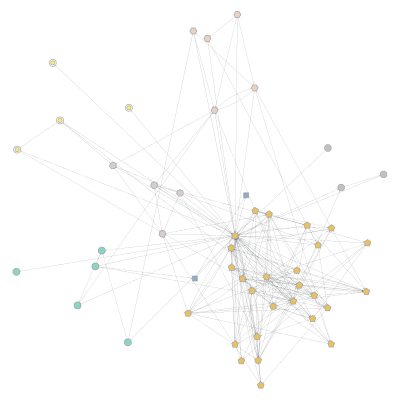


Streaming Graph at Stage 3


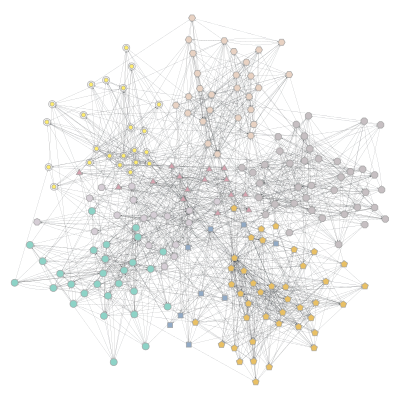


Streaming Graph at Stage 6


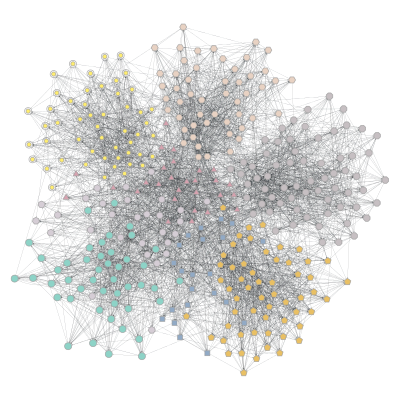


Streaming Graph at Stage 9


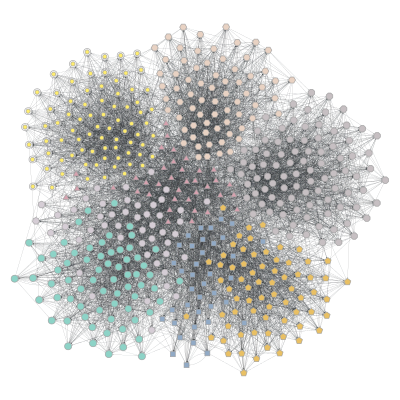

In [6]:
input_filename = 'simulated_blockmodel_graph_500_nodes_snowball'
num_stages = 10; # number of graph stages to load
out_neighbors = [None] * num_stages
in_neighbors = [None] * num_stages

out_neighbors[0], in_neighbors[0], N, E, true_partition = load_graph(input_filename, True, 1)
for i in range(1, num_stages):
    out_neighbors[i], in_neighbors[i], N, E = load_graph(input_filename, False, i+1, out_neighbors[i-1], in_neighbors[i-1])

graph_object = gt.Graph()
graph_object.add_edge_list([(i,j) for i in range(len(out_neighbors[num_stages-1])) if len(out_neighbors[num_stages-1][i])>0 for j in out_neighbors[num_stages-1][i][:,0]])
pos = gt.sfdp_layout(graph_object).get_2d_array(range(2)).transpose()
for i in range(0, num_stages, 3): 
    print('\nStreaming Graph at Stage {}'.format(i))
    plot_graph_with_partition(out_neighbors[i], true_partition, pos=pos)